In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display

In [27]:
# raw_data1 = pd.read_csv('data\ods032.csv', delimiter=';', parse_dates=['Datetime'], index_col='Datetime')
raw_data2 = pd.read_csv('data\ods032.csv', delimiter=';')

In [87]:
data = raw_data2.copy()
data = data[data.Region == "Belgium"]
data['Datetime'] = pd.to_datetime(data['Datetime'], utc=True)
data = data[['Datetime','Measured & Upscaled']]
data = data.rename(columns={'Measured & Upscaled':'generation'})
data.set_index("Datetime", inplace=True)
data = data.sort_index()
data = data['2019-01-01':'2023-12-31']
data = data.ffill().bfill()
data = data['generation'].values.reshape(-1, 1)
data

,generation,day_of_year,hour_sin,hour_cos
Datetime,,,,
2019-01-01 00:00:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 00:15:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 00:30:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 00:45:00+00:00,0.0,0.00274,0.000000,1.000000
2019-01-01 01:00:00+00:00,0.0,0.00274,0.258819,0.965926
...,...,...,...,...
2023-12-31 22:45:00+00:00,0.0,1.00000,-0.500000,0.866025
2023-12-31 23:00:00+00:00,0.0,1.00000,-0.258819,0.965926
2023-12-31 23:15:00+00:00,0.0,1.00000,-0.258819,0.965926


<Axes: xlabel='Datetime', ylabel='generation'>

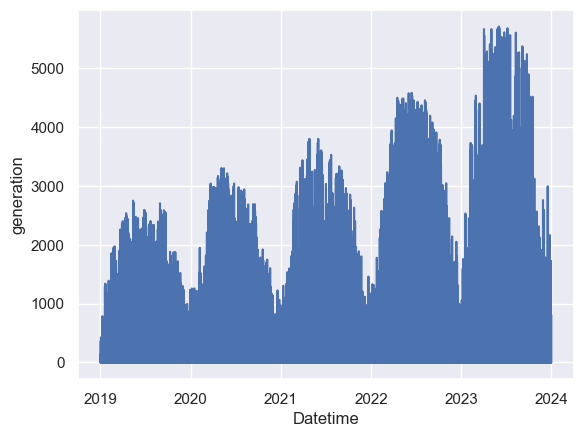

In [91]:
sns.lineplot(data.generation)

In [70]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Set sequence length (e.g., 96 timesteps = past 24 hours)
seq_len = 96

# Create sequences and labels
X = []
y = []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i-seq_len:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# # Reshape X for LSTM input (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [73]:
print(f'zeroes:\t\t{len(scaled_data[scaled_data==0]):,}')
print(f'non-zeroes:\t{len(scaled_data[scaled_data>0]):,}')

zeroes:		83,804
non-zeroes:	91,492


In [74]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [75]:
# history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)
history = model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
2190/2190 [==============================] - 78s 34ms/step - loss: 3.3977e-04 - val_loss: 1.0205e-04
Epoch 2/5
2190/2190 [==============================] - 71s 32ms/step - loss: 4.9407e-05 - val_loss: 6.6183e-05
Epoch 3/5
2190/2190 [==============================] - 73s 33ms/step - loss: 4.2659e-05 - val_loss: 6.2356e-05
Epoch 4/5
2190/2190 [==============================] - 77s 35ms/step - loss: 4.1129e-05 - val_loss: 6.4758e-05
Epoch 5/5
2190/2190 [==============================] - 82s 37ms/step - loss: 3.9658e-05 - val_loss: 6.9711e-05


In [84]:
# Get last sequence
last_sequence = scaled_data[-seq_len:]
last_sequence = last_sequence.reshape((1, seq_len, 1))

# Predict the next 7 days (672 timesteps)
predicted_values = []
for _ in range(672):
    predicted_value = model.predict(last_sequence)
    predicted_values.append(predicted_value[0, 0])  # Store the predicted value
    
    # Update the last_sequence with the predicted value
    predicted_value_reshaped = predicted_value.reshape(1, 1, 1)  # Reshape to (1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], predicted_value_reshaped, axis=1)

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))
print(predicted_values)

1/1 [==============================] - 0s 43ms/step
[[-1.09339314e+01]
 [-2.95013809e+01]
 [-5.52770996e+01]
 [-8.84701843e+01]
 [-1.28741806e+02]
 [-1.75665573e+02]
 [-2.28811890e+02]
 [-2.87813568e+02]
 [-3.52412231e+02]
 [-4.22493591e+02]
 [-4.98117859e+02]
 [-5.79550415e+02]
 [-6.67299561e+02]
 [-7.62165344e+02]
 [-8.65307678e+02]
 [-9.78343323e+02]
 [-1.10348291e+03]
 [-1.24372876e+03]
 [-1.40315637e+03]
 [-1.58732007e+03]
 [-1.80382703e+03]
 [-2.06314453e+03]
 [-2.37969458e+03]
 [-2.77325293e+03]
 [-3.27053027e+03]
 [-3.90647803e+03]
 [-4.72398438e+03]
 [-5.76827979e+03]
 [-7.06750928e+03]
 [-8.59026953e+03]
 [-1.01993701e+04]
 [-1.16713018e+04]
 [-1.28009785e+04]
 [-1.34751943e+04]
 [-1.36593594e+04]
 [-1.33710381e+04]
 [-1.26826865e+04]
 [-1.17130596e+04]
 [-1.05617939e+04]
 [-9.31380859e+03]
 [-8.11427100e+03]
 [-7.18118018e+03]
 [-6.80228662e+03]
 [-7.25608398e+03]
 [-8.67260156e+03]
 [-1.09196416e+04]
 [-1.36052979e+04]
 [-1.60517793e+04]
 [-1.76142090e+04]
 [-1.83206250e+04

<Axes: >

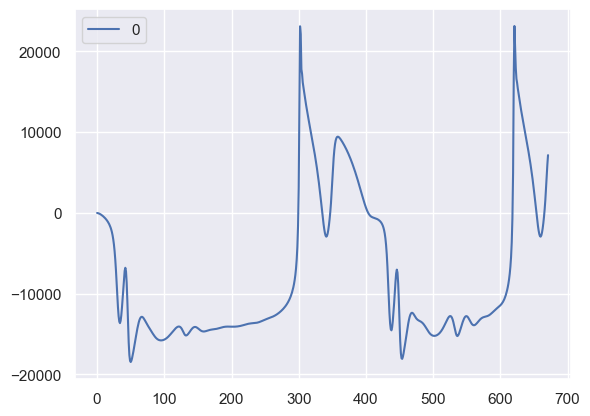

In [86]:
sns.lineplot(predicted_values)